# ノートブック11: モデル比較と選択

## 学習目標

このノートブックでは、複数の機械学習モデルを体系的に比較し、最適なモデルを選択する手法を学びます:

1. **公平な比較**
   - クロスバリデーション
   - 同じデータ分割
   - 標準化された評価指標

2. **統計的検定**
   - t検定による有意差の検証
   - モデル間の性能差

3. **アンサンブル手法**
   - Voting (Hard/Soft)
   - Stacking
   - 性能向上の仕組み

4. **選択基準**
   - 性能 vs 解釈性
   - 訓練時間 vs 予測時間
   - 過学習のリスク

5. **実践的な意思決定**
   - ビジネス要件
   - 運用制約
   - コストベネフィット分析

---

## セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, f1_score
)
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
np.random.seed(42)

print("Setup complete!")

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


Setup complete!


---

## 1. モデル比較の基礎

### 🎯 なぜ「公平な比較」が重要なのか？

機械学習では多くのアルゴリズムが利用可能ですが、
「どれが最良か」を判断するには**公平な条件**での比較が必須です。

```
【不公平な比較の例】

❌ モデルAは訓練データで評価、モデルBはテストデータで評価
❌ モデルAはスケーリングあり、モデルBはスケーリングなし
❌ モデルAは10回試行の最良値、モデルBは1回だけ
❌ データの分割がモデルごとに異なる

→ これらは「リンゴとオレンジの比較」であり、意味がない


【公平な比較の原則】

✓ 同じデータ分割（訓練/テスト）
✓ 同じ前処理（スケーリング、欠損値処理）
✓ 同じ評価指標
✓ 同じクロスバリデーション設定
✓ 統計的に有意な差かを検証
```

---

### 📊 モデル比較で考慮すべき観点

```
【性能 (Performance)】

  - 予測精度（Accuracy, F1, AUC）
  - 汎化性能（未知データでの精度）
  
  「最も正確に予測できるのは？」


【安定性 (Stability)】

  - CVスコアの標準偏差
  - 異なるデータでの一貫性
  
  「結果がブレないのは？」


【効率性 (Efficiency)】

  - 訓練時間
  - 予測時間
  - メモリ使用量
  
  「リソースを効率的に使えるのは？」


【解釈性 (Interpretability)】

  - 予測の説明可能性
  - 特徴量の重要度
  
  「なぜその予測になったか説明できる？」


【過学習リスク (Overfitting Risk)】

  - 訓練スコアとテストスコアの差
  - モデルの複雑さ
  
  「未知データでも性能を維持できる？」
```

---

### 🔄 バイアス-バリアンストレードオフ

モデル選択の背後にある重要な概念です。

```
【バイアス (Bias)】

  = モデルの「単純化」による誤差
  
  例: 曲線的なデータに直線を当てはめる
  
  高バイアスなモデル:
    - ロジスティック回帰
    - Naive Bayes
  
  症状: 訓練でもテストでも精度が低い（未学習）


【バリアンス (Variance)】

  = データの変動に対する「敏感さ」
  
  例: 訓練データの微小な変化で結果が大きく変わる
  
  高バリアンスなモデル:
    - 深い決定木
    - 過度に複雑なニューラルネットワーク
  
  症状: 訓練は完璧、テストで精度低下（過学習）


【トレードオフの図解】

  誤差
   ↑
   │  ╲          ╱  ← テスト誤差
   │    ╲      ╱
   │      ╲──╱    ← 最適点
   │      ╱  ╲
   │    ╱      ────  ← 訓練誤差
   │  ╱
   └──────────────→ モデルの複雑さ
     単純        複雑


【各モデルの位置づけ】

  単純（高バイアス）          複雑（高バリアンス）
  ←────────────────────────────────────────→
  
  Naive Bayes    SVM    Random Forest    Deep NN
  Linear         KNN    Gradient Boost   決定木(深い)
```

---

### 📋 今回比較するモデル

| モデル | 特徴 | バイアス | バリアンス |
|--------|------|---------|-----------|
| Logistic Regression | 線形、解釈容易 | 高 | 低 |
| KNN | 非パラメトリック | 低〜中 | 中〜高 |
| Naive Bayes | 確率的、高速 | 高 | 低 |
| Decision Tree | 解釈容易 | 低 | 高 |
| Random Forest | アンサンブル | 低 | 中 |
| Gradient Boosting | アンサンブル | 低 | 中 |
| SVM | カーネル法 | 低 | 中 |
| MLP | ニューラルネット | 低 | 中〜高 |

### データを準備しましょう

In [2]:
# データ生成
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=15,
    n_redundant=3,
    n_classes=3,
    n_clusters_per_class=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(X_train)}, Test: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(np.unique(y))}")

# ベースライン: ランダム予測
baseline_accuracy = max(np.bincount(y_train)) / len(y_train)
print(f"\nBaseline (majority class): {baseline_accuracy:.4f}")

Training: 1600, Test: 400
Features: 20
Classes: 3

Baseline (majority class): 0.3350


---

## 2. モデル定義と初期評価

### 🔍 クロスバリデーション（CV）とは？

単純なTrain/Test分割には問題があります。

```
【単純分割の問題】

  データ: [=====================================]
  
  分割1:  [======訓練======][==テスト==]  → 精度 85%
  分割2:  [==テスト==][======訓練======]  → 精度 78%
  分割3:  [===][======訓練======][===]    → 精度 82%
  
  問題: どの分割を使うかで結果が変わる！
  → 「たまたま良いテストデータ」に当たった可能性


【クロスバリデーションの解決策】

  K-Fold CV（K=5の例）:
  
  Fold 1: [テスト][訓練][訓練][訓練][訓練] → 精度 84%
  Fold 2: [訓練][テスト][訓練][訓練][訓練] → 精度 82%
  Fold 3: [訓練][訓練][テスト][訓練][訓練] → 精度 85%
  Fold 4: [訓練][訓練][訓練][テスト][訓練] → 精度 81%
  Fold 5: [訓練][訓練][訓練][訓練][テスト] → 精度 83%
  
  平均: 83% (+/- 1.4%)
  
  → すべてのデータがテストに使われる
  → 結果がより安定・信頼できる
```

---

### 📊 Stratified K-Fold

クラス不均衡がある場合に重要です。

```
【通常のK-Fold の問題】

  元データ: クラスA 80%, クラスB 20%
  
  Fold 1 のテスト: クラスA 90%, クラスB 10%  ← 偏り
  Fold 2 のテスト: クラスA 70%, クラスB 30%  ← 偏り
  
  → 各フォールドでクラス分布が異なる
  → 評価が不公平に


【Stratified K-Fold の解決策】

  元データ: クラスA 80%, クラスB 20%
  
  Fold 1 のテスト: クラスA 80%, クラスB 20%  ← 同じ比率
  Fold 2 のテスト: クラスA 80%, クラスB 20%  ← 同じ比率
  
  → 各フォールドで元のクラス分布を維持
  → 公平な評価が可能
```

---

### ⚙️ CVの設定ポイント

| パラメータ | 推奨値 | 理由 |
|-----------|--------|------|
| n_splits (K) | 5〜10 | 5が標準、データが少なければ10 |
| shuffle | True | データの順序依存を排除 |
| stratify | True | クラス分布を維持（分類問題） |

```python
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(
    n_splits=10,      # 10分割
    shuffle=True,     # シャッフル
    random_state=42   # 再現性
)
```

### 8つのモデルを定義して比較しましょう

In [3]:
# 比較するモデルを定義
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, 
                         early_stopping=True, random_state=42)
}

print(f"Comparing {len(models)} models")
print("\nModel List:")
for i, name in enumerate(models.keys(), 1):
    print(f"  {i}. {name}")

Comparing 8 models

Model List:
  1. Logistic Regression
  2. KNN
  3. Naive Bayes
  4. Decision Tree
  5. Random Forest
  6. Gradient Boosting
  7. SVM
  8. MLP


### クロスバリデーションによる比較

In [4]:
# 10-fold クロスバリデーション
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {}
cv_scores = {}
training_times = {}

print("Cross-Validation Results (10-fold):")
print("="*70)

for name, model in models.items():
    # 訓練時間の測定
    start_time = time.time()
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    train_time = time.time() - start_time
    
    cv_scores[name] = scores
    training_times[name] = train_time
    
    results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'min': scores.min(),
        'max': scores.max(),
        'time': train_time
    }
    
    print(f"{name:22s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Time: {train_time:.2f}s")

# ランキング
sorted_results = sorted(results.items(), key=lambda x: x[1]['mean'], reverse=True)

print("\nRanking by CV Accuracy:")
print("="*70)
for rank, (name, res) in enumerate(sorted_results, 1):
    print(f"{rank:2d}. {name:22s}: {res['mean']:.4f} (+/- {res['std']:.4f})")

Cross-Validation Results (10-fold):
Logistic Regression   : 0.6969 (+/- 0.0222) | Time: 0.07s


KNN                   : 0.8719 (+/- 0.0210) | Time: 0.32s
Naive Bayes           : 0.6750 (+/- 0.0332) | Time: 0.02s


Decision Tree         : 0.6469 (+/- 0.0278) | Time: 0.21s


Random Forest         : 0.8481 (+/- 0.0190) | Time: 4.18s


Gradient Boosting     : 0.8088 (+/- 0.0231) | Time: 21.69s


SVM                   : 0.9181 (+/- 0.0252) | Time: 2.48s


MLP                   : 0.9012 (+/- 0.0185) | Time: 3.63s

Ranking by CV Accuracy:
 1. SVM                   : 0.9181 (+/- 0.0252)
 2. MLP                   : 0.9012 (+/- 0.0185)
 3. KNN                   : 0.8719 (+/- 0.0210)
 4. Random Forest         : 0.8481 (+/- 0.0190)
 5. Gradient Boosting     : 0.8088 (+/- 0.0231)
 6. Logistic Regression   : 0.6969 (+/- 0.0222)
 7. Naive Bayes           : 0.6750 (+/- 0.0332)
 8. Decision Tree         : 0.6469 (+/- 0.0278)


### 結果の可視化

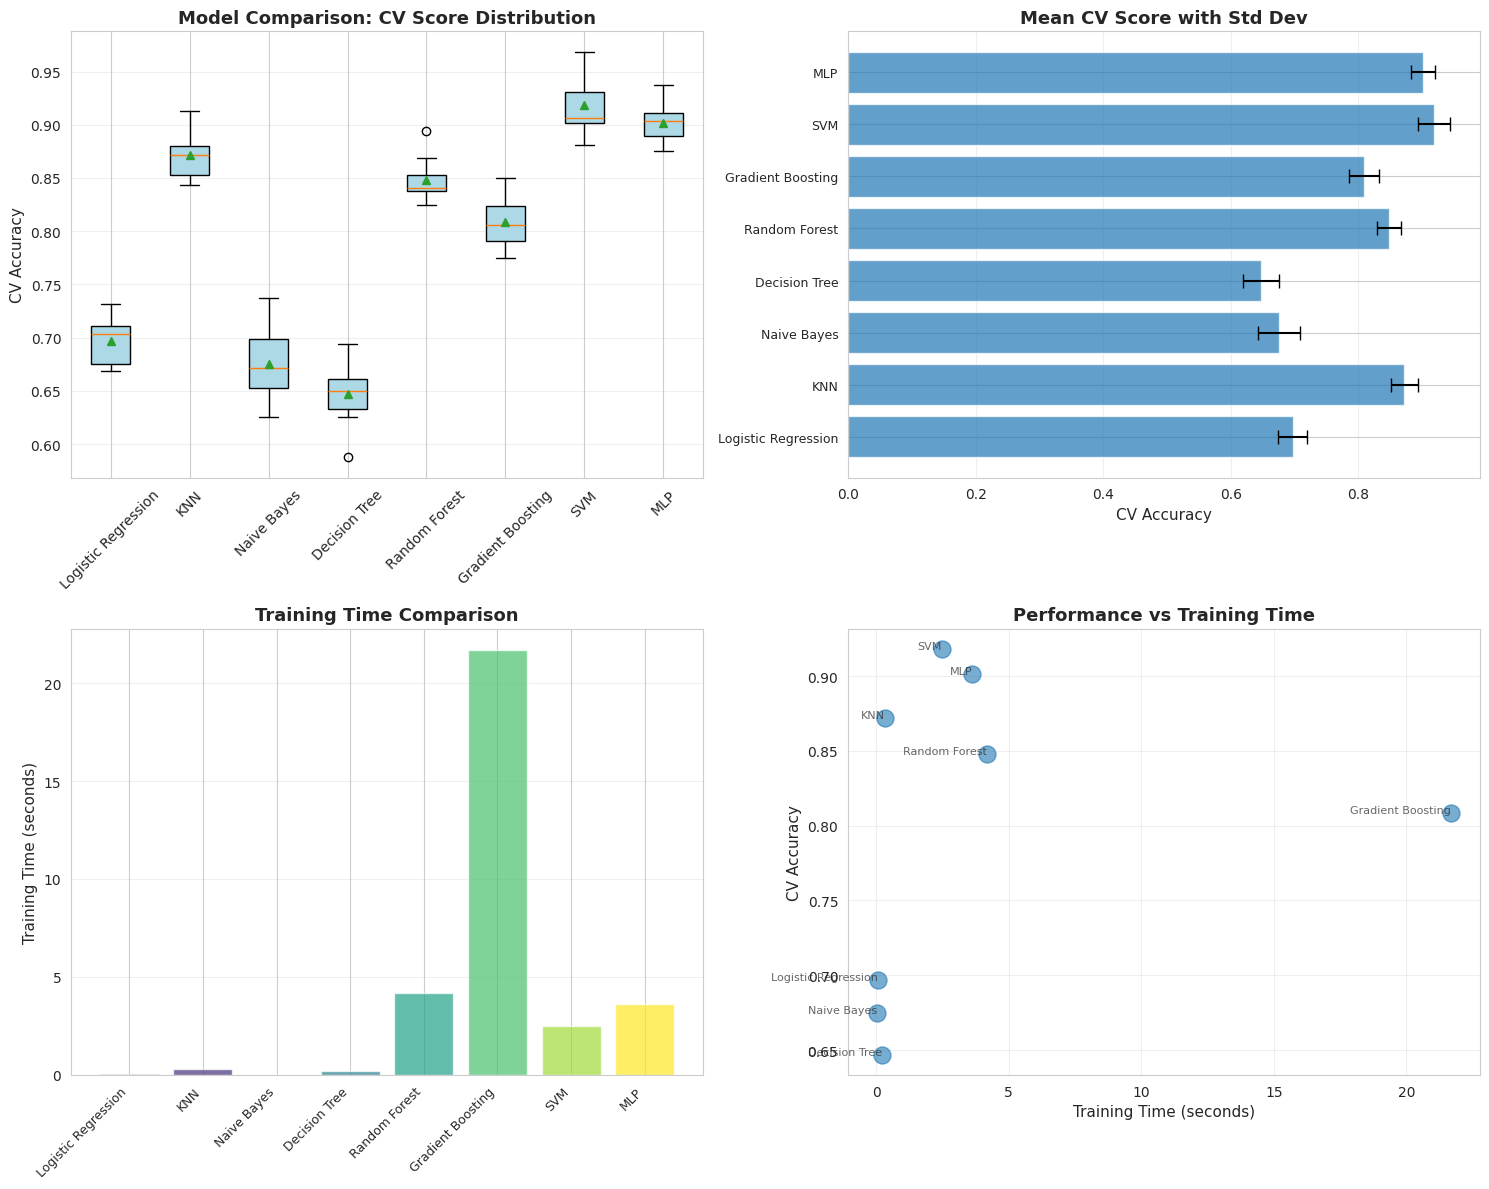


Key Observations:
- Top-right in performance/time plot: Best tradeoff
- Low variance across folds: More stable model
- Fast training: Better for iterative development


In [5]:
# CV結果の包括的な可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ボックスプロット
names = list(cv_scores.keys())
scores_list = [cv_scores[name] for name in names]

bp = axes[0, 0].boxplot(scores_list, labels=names, patch_artist=True, showmeans=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0, 0].set_ylabel('CV Accuracy', fontsize=11)
axes[0, 0].set_title('Model Comparison: CV Score Distribution', fontsize=13, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. 平均スコアとエラーバー
means = [results[name]['mean'] for name in names]
stds = [results[name]['std'] for name in names]
x_pos = np.arange(len(names))

axes[0, 1].barh(x_pos, means, xerr=stds, capsize=5, alpha=0.7)
axes[0, 1].set_yticks(x_pos)
axes[0, 1].set_yticklabels(names, fontsize=9)
axes[0, 1].set_xlabel('CV Accuracy', fontsize=11)
axes[0, 1].set_title('Mean CV Score with Std Dev', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. 訓練時間
times = [training_times[name] for name in names]
colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
axes[1, 0].bar(range(len(names)), times, color=colors, alpha=0.7)
axes[1, 0].set_xticks(range(len(names)))
axes[1, 0].set_xticklabels(names, rotation=45, ha='right', fontsize=9)
axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=11)
axes[1, 0].set_title('Training Time Comparison', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. 性能 vs 訓練時間
axes[1, 1].scatter(times, means, s=150, alpha=0.6)
for i, name in enumerate(names):
    axes[1, 1].annotate(name, (times[i], means[i]), 
                        fontsize=8, ha='right', alpha=0.7)
axes[1, 1].set_xlabel('Training Time (seconds)', fontsize=11)
axes[1, 1].set_ylabel('CV Accuracy', fontsize=11)
axes[1, 1].set_title('Performance vs Training Time', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Top-right in performance/time plot: Best tradeoff")
print("- Low variance across folds: More stable model")
print("- Fast training: Better for iterative development")

---

## 3. 統計的有意性検定

### 🤔 なぜ統計的検定が必要？

CVスコアを見ただけでは判断を誤る可能性があります。

```
【問題のある判断】

  モデルA: CV精度 85.2% (+/- 2.1%)
  モデルB: CV精度 84.8% (+/- 2.3%)
  
  「Aの方が0.4%高いからAが良い！」
  
  → 本当に？この差は「偶然」かもしれない


【統計的検定の役割】

  「この差が偶然である確率」を計算
  
  p値 = 0.6 → 差は偶然の可能性が高い（有意でない）
  p値 = 0.02 → 差は偶然ではなさそう（有意）
  
  通常 p < 0.05 で「統計的に有意な差がある」と判断
```

---

### 📊 対応のあるt検定（Paired t-test）

なぜ「対応のある」検定を使うのか？

```
【対応のある vs 対応のない】

対応のない検定:
  モデルA: [Fold1: 85, Fold2: 83, Fold3: 87, ...]
  モデルB: [Fold1: 82, Fold2: 86, Fold3: 84, ...]
  
  → 各フォールドの「ペア」を無視
  → 情報が失われる


対応のある検定:
  Fold1: AはBより3%高い (85 - 82 = +3)
  Fold2: AはBより3%低い (83 - 86 = -3)
  Fold3: AはBより3%高い (87 - 84 = +3)
  
  → 各フォールドでの「差」を分析
  → より精密な検定が可能


【なぜ対応があるのか？】

  同じデータ分割（Fold）で両モデルを評価
  
  Fold 1 ─┬→ モデルA を評価
          └→ モデルB を評価（同じデータで）
  
  → Fold 1 の結果は「ペア」になっている
  → 対応のあるt検定が適切
```

---

### 🔢 t検定の数学的背景

```
【検定統計量 t】

       d̄            差の平均
  t = ────  =  ─────────────────
      SE_d     差の標準誤差

  d̄ = 各フォールドでの差の平均
  SE_d = 差の標準偏差 / √n


【p値の解釈】

  p値 = 「差がゼロである」という仮説のもとで、
        今回の差（以上の差）が観測される確率
  
  p = 0.03 の意味:
    「本当は差がないのに、今回の差が観測される確率は3%」
    → 3%は十分小さい → 差がないとは考えにくい
    → 有意な差がある！


【有意水準 α】

  α = 0.05（5%）が標準
  
  p < α → 帰無仮説を棄却（有意な差あり）
  p ≥ α → 帰無仮説を棄却できない（有意な差なし）
  
  注意: 「差がない」ことが証明されたわけではない！
```

---

### ⚠️ 多重比較の問題

複数のモデルを比較する際の注意点です。

```
【問題】

  8モデルをペアワイズ比較 = 28回の検定
  
  各検定で α = 0.05（偽陽性率5%）
  
  28回のうち1回以上偽陽性が出る確率:
    1 - (1 - 0.05)^28 ≈ 76%
  
  → 本当は差がないのに「差がある」と
    誤って判断する可能性が76%！


【対策: Bonferroni補正】

  補正後の α = 0.05 / 28 ≈ 0.0018
  
  より厳しい基準で判断
  
  ただし、過度に保守的になる欠点も


【実践的なアドバイス】

  1. 事前に比較対象を絞る（全ペア比較を避ける）
  2. 最良モデル vs 他のみ比較
  3. 効果量（Effect Size）も確認
  4. p値だけでなく実際の差の大きさも考慮
```

### t検定でモデル間の有意差を検証しましょう

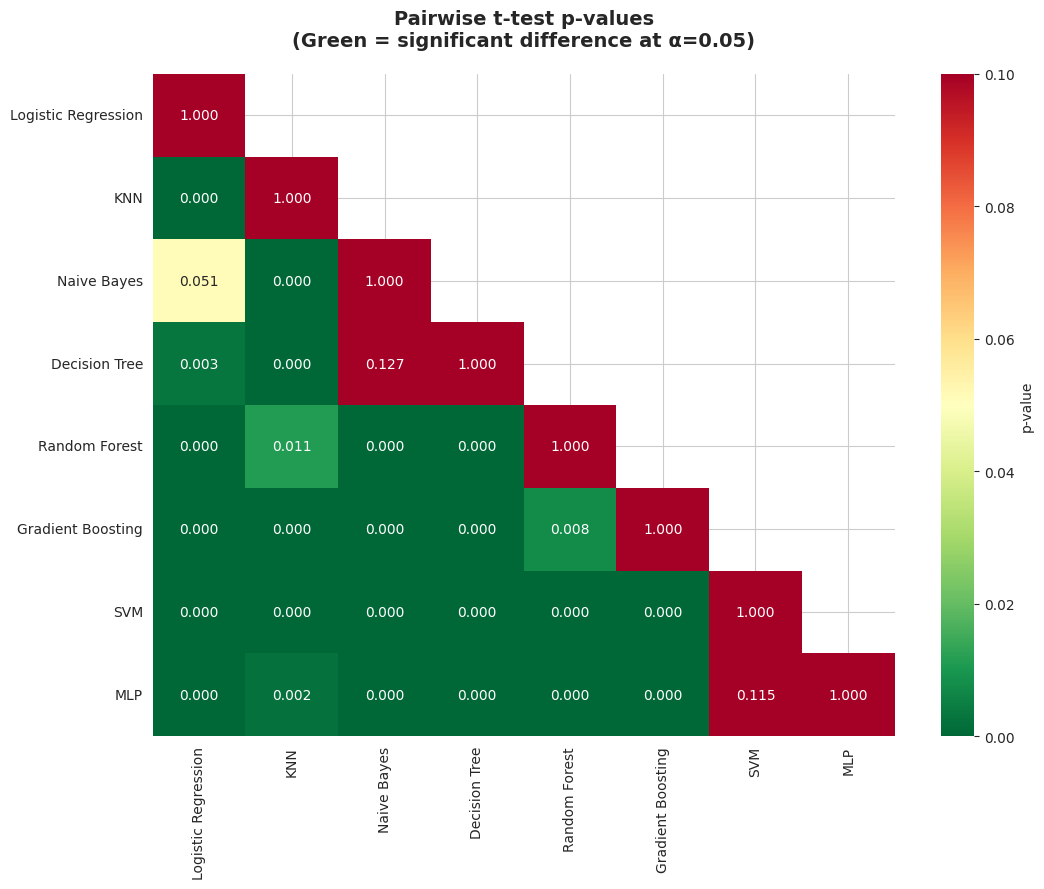


Interpretation:
- p < 0.05: Statistically significant difference (green)
- p > 0.05: No significant difference (red)

Significant pairs:
  Logistic Regression vs KNN: p=0.0000 → KNN is better
  Logistic Regression vs Decision Tree: p=0.0029 → Logistic Regression is better
  Logistic Regression vs Random Forest: p=0.0000 → Random Forest is better
  Logistic Regression vs Gradient Boosting: p=0.0000 → Gradient Boosting is better
  Logistic Regression vs SVM: p=0.0000 → SVM is better
  Logistic Regression vs MLP: p=0.0000 → MLP is better
  KNN vs Naive Bayes: p=0.0000 → KNN is better
  KNN vs Decision Tree: p=0.0000 → KNN is better
  KNN vs Random Forest: p=0.0110 → KNN is better
  KNN vs Gradient Boosting: p=0.0002 → KNN is better
  KNN vs SVM: p=0.0002 → SVM is better
  KNN vs MLP: p=0.0023 → MLP is better
  Naive Bayes vs Random Forest: p=0.0000 → Random Forest is better
  Naive Bayes vs Gradient Boosting: p=0.0000 → Gradient Boosting is better
  Naive Bayes vs SVM: p=0.0000 → SVM is 

In [6]:
# ペアワイズt検定
model_names = list(cv_scores.keys())
n_models = len(model_names)

p_values = np.ones((n_models, n_models))

for i in range(n_models):
    for j in range(i+1, n_models):
        # 対応のあるt検定
        t_stat, p_value = stats.ttest_rel(cv_scores[model_names[i]], 
                                          cv_scores[model_names[j]])
        p_values[i, j] = p_value
        p_values[j, i] = p_value

# ヒートマップで可視化
plt.figure(figsize=(11, 9))
mask = np.triu(np.ones_like(p_values, dtype=bool), k=1)
sns.heatmap(p_values, annot=True, fmt='.3f', cmap='RdYlGn_r',
            xticklabels=model_names, yticklabels=model_names,
            mask=mask, vmin=0, vmax=0.1, cbar_kws={'label': 'p-value'})
plt.title('Pairwise t-test p-values\n(Green = significant difference at α=0.05)',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- p < 0.05: Statistically significant difference (green)")
print("- p > 0.05: No significant difference (red)")
print("\nSignificant pairs:")
for i in range(n_models):
    for j in range(i+1, n_models):
        if p_values[i, j] < 0.05:
            better = model_names[i] if results[model_names[i]]['mean'] > results[model_names[j]]['mean'] else model_names[j]
            print(f"  {model_names[i]} vs {model_names[j]}: p={p_values[i, j]:.4f} → {better} is better")

---

## 4. テストセット評価と過学習診断

### 🔍 過学習（Overfitting）とは？

```
【過学習の定義】

  訓練データに「過度に適合」し、
  未知のデータに対する性能が低下する現象
  
  
【症状】

  訓練精度:   98%  ← 非常に高い
  テスト精度: 75%  ← 大幅に低い
  ────────────────
  ギャップ:   23%  ← 過学習の指標
  
  
【なぜ起こるか？】

  モデルが訓練データの「ノイズ」まで学習
  
  本来のパターン: y = 2x + 3
  ノイズ込みの学習: y = 2.1x + 2.8 - 0.05x² + 0.01x³ + ...
                              ↑ ノイズを学習
```

---

### 📊 過学習の診断基準

| Train-Test ギャップ | 診断 | 対処 |
|-------------------|------|------|
| < 0.05 (5%) | 良好 | 問題なし |
| 0.05〜0.10 | 許容範囲 | 注意して観察 |
| 0.10〜0.20 | 過学習の兆候 | 正則化を検討 |
| > 0.20 | 深刻な過学習 | モデル見直し必須 |

```
【過学習しやすいモデル】

  高リスク:
    - 深い決定木 (max_depth制限なし)
    - パラメータ数が多いNN
    - 正則化なしのモデル
  
  低リスク:
    - ロジスティック回帰（線形）
    - Naive Bayes（単純な仮定）
    - 適切に正則化されたモデル
```

---

### 🛠️ 過学習への対処法

```
【モデルの複雑さを下げる】

  決定木: max_depth を小さく
  NN: hidden_layer_sizes を小さく
  
  → バリアンスを下げる


【正則化を強くする】

  L2正則化: alpha を大きく
  Dropout: rate を大きく
  
  → パラメータの自由度を制限


【訓練データを増やす】

  → ノイズの影響を相対的に減らす
  → 本質的なパターンを学習しやすく


【アンサンブル手法】

  Random Forest: 複数の木の平均
  Bagging: 複数モデルの平均
  
  → 個々のモデルの過学習を相殺
```

### 全モデルをテストデータで評価しましょう

In [7]:
# すべてのモデルでテストセット評価
test_results = []

for name, model in models.items():
    # 訓練
    model.fit(X_train_scaled, y_train)
    
    # 評価
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    
    # 予測時間
    start_time = time.time()
    _ = model.predict(X_test_scaled)
    pred_time = time.time() - start_time
    
    test_results.append({
        'Model': name,
        'Train': train_score,
        'Test': test_score,
        'Overfit': train_score - test_score,
        'Pred_Time_ms': pred_time * 1000
    })

df_test = pd.DataFrame(test_results).sort_values('Test', ascending=False)

print("Test Set Results:")
print("="*80)
print(df_test.to_string(index=False))

print("\nOverfitting Analysis:")
print("  High overfitting (>0.10): Risk of poor generalization")
print("  Moderate (0.05-0.10): Acceptable")
print("  Low (<0.05): Good generalization")

Test Set Results:
              Model    Train   Test  Overfit  Pred_Time_ms
                MLP 0.985000 0.9100 0.075000      0.644207
                SVM 0.961250 0.9000 0.061250     17.501354
                KNN 0.922500 0.8750 0.047500      6.372452
      Random Forest 1.000000 0.8525 0.147500      9.600878
  Gradient Boosting 0.958750 0.8050 0.153750      2.841473
Logistic Regression 0.709375 0.7025 0.006875      0.116825
      Decision Tree 0.968750 0.6875 0.281250      0.141144
        Naive Bayes 0.690625 0.6775 0.013125      0.243664

Overfitting Analysis:
  High overfitting (>0.10): Risk of poor generalization
  Moderate (0.05-0.10): Acceptable
  Low (<0.05): Good generalization


---

## 5. アンサンブル手法

### 🤝 アンサンブルとは？

複数のモデルを組み合わせて、より良い予測を得る手法です。

```
【なぜアンサンブルが有効なのか？】

  個々のモデルには「得意・不得意」がある
  
  サンプル1: モデルA ✓ モデルB ✗ モデルC ✓ → 多数決で ✓
  サンプル2: モデルA ✗ モデルB ✓ モデルC ✓ → 多数決で ✓
  サンプル3: モデルA ✓ モデルB ✓ モデルC ✗ → 多数決で ✓
  
  → 個々のモデルの弱点を補い合う


【数学的な背景：誤差の相殺】

  各モデルの予測 = 真の値 + バイアス + ランダム誤差
  
  複数モデルの平均:
    ランダム誤差は打ち消し合う → 精度向上
    バイアスは残る → 多様なモデルが必要
```

---

### 🗳️ Voting（投票法）

#### Hard Voting（多数決）

```
【仕組み】

  サンプルXの予測:
    モデルA: クラス1
    モデルB: クラス2
    モデルC: クラス1
    ─────────────────
    多数決 → クラス1（2票 vs 1票）


【利点】
  - シンプルで解釈しやすい
  - 確率を出力できないモデルでも使える

【欠点】
  - 予測の「確信度」を考慮しない
```

#### Soft Voting（確率平均）

```
【仕組み】

  サンプルXの予測（確率）:
              クラス0  クラス1  クラス2
    モデルA:   0.1      0.7      0.2
    モデルB:   0.2      0.3      0.5
    モデルC:   0.1      0.6      0.3
    ────────────────────────────────────
    平均:      0.13     0.53     0.33
    
    → クラス1（確率0.53で最大）


【利点】
  - 確信度を考慮
  - 通常Hard Votingより高精度

【欠点】
  - 確率を出力できるモデルのみ
  - SVMは probability=True が必要
```

---

### 📚 Stacking（スタッキング）

2段階の学習を行う、より高度なアンサンブル手法です。

```
【Stackingの仕組み】

Level 0（ベースモデル）:
  
  入力X ─┬→ Random Forest  ─→ 予測1
         ├→ Gradient Boost ─→ 予測2
         └→ SVM            ─→ 予測3

Level 1（メタモデル）:
  
  [予測1, 予測2, 予測3] ─→ Logistic Regression ─→ 最終予測


【なぜ2段階？】

  Level 0: 異なる視点からデータを分析
  Level 1: 各モデルの「信頼度」を学習
  
  例:
    「Random Forestが自信を持っている時は信頼する」
    「SVMとGBが一致している時は正しい可能性が高い」
  
  → メタモデルがこれらのパターンを学習


【注意: 過学習を防ぐCVの使用】

  ❌ ベースモデルを全訓練データで学習し、
     その予測でメタモデルを訓練
     → ベースモデルが「答えを知っている」
     → データリーク！

  ✓ CVを使用（sklearn の StackingClassifier）
     各 Fold で:
       ベースモデルを訓練データで学習
       検証データの予測を保存
     → 全予測を集めてメタモデルを訓練
```

---

### 📊 アンサンブル手法の比較

| 手法 | 複雑さ | 性能 | 解釈性 | 訓練時間 |
|------|--------|------|--------|----------|
| Hard Voting | ⭐ | ⭐⭐ | ⭐⭐⭐ | ⭐⭐ |
| Soft Voting | ⭐⭐ | ⭐⭐⭐ | ⭐⭐ | ⭐⭐ |
| Stacking | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐ | ⭐ |

```
【選び方】

  とりあえず試す → Soft Voting
  最高精度を目指す → Stacking
  解釈性が必要 → Hard Voting
  計算リソースが限られる → Voting
```

---

### 🎯 良いアンサンブルの条件

```
【多様性 (Diversity)】

  ❌ 同じ種類のモデル3つ
     Random Forest + Random Forest + Random Forest
     → 同じ間違いをする → 効果薄い

  ✓ 異なる種類のモデル
     Random Forest + SVM + MLP
     → 異なる視点 → 補い合える


【個々の性能】

  ❌ 弱いモデルを多く集める
     → 「ゴミを集めてもゴミ」

  ✓ ある程度強いモデルを組み合わせる
     → 各モデルが貢献できる
```

### 3種類のアンサンブルを試しましょう

In [8]:
# Voting Classifier (Hard Voting)
voting_hard = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, 
                              early_stopping=True, random_state=42))
    ],
    voting='hard'
)

# Voting Classifier (Soft Voting)
voting_soft = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500,
                              early_stopping=True, random_state=42))
    ],
    voting='soft'
)

# Stacking Classifier
stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# アンサンブルモデルの評価
print("Ensemble Methods:")
print("="*70)

ensemble_results = []
for name, model in [('Hard Voting', voting_hard), 
                    ('Soft Voting', voting_soft), 
                    ('Stacking', stacking)]:
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    
    ensemble_results.append({
        'Method': name,
        'CV Mean': scores.mean(),
        'CV Std': scores.std(),
        'Test': test_score
    })
    
    print(f"\n{name}:")
    print(f"  CV Score:   {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  Test Score: {test_score:.4f}")

df_ensemble = pd.DataFrame(ensemble_results)
print("\nEnsemble Summary:")
print(df_ensemble.to_string(index=False))

Ensemble Methods:



Hard Voting:
  CV Score:   0.8538 (+/- 0.0105)
  Test Score: 0.8675



Soft Voting:
  CV Score:   0.8681 (+/- 0.0080)
  Test Score: 0.8800



Stacking:
  CV Score:   0.9006 (+/- 0.0176)
  Test Score: 0.8875

Ensemble Summary:
     Method  CV Mean   CV Std   Test
Hard Voting 0.853750 0.010533 0.8675
Soft Voting 0.868125 0.008004 0.8800
   Stacking 0.900625 0.017611 0.8875


---

## 6. 最終モデル選択

### 🎯 モデル選択の意思決定フレームワーク

モデル選択は単に「精度が高いもの」を選ぶだけではありません。

```
【考慮すべき要素】

┌─────────────────────────────────────────────────────────┐
│                    モデル選択                           │
├─────────────────────────────────────────────────────────┤
│                                                         │
│   性能要件          運用要件          ビジネス要件      │
│   ─────────        ─────────        ─────────          │
│   ・精度           ・訓練時間        ・解釈性           │
│   ・汎化性能       ・予測速度        ・規制対応         │
│   ・安定性         ・メモリ使用      ・メンテナンス     │
│   ・過学習         ・スケーラビリティ ・コスト          │
│                                                         │
└─────────────────────────────────────────────────────────┘
```

---

### 📋 要件別モデル選択ガイド

```
【解釈性が最重要の場合】

  医療診断、金融与信、法的決定など
  
  推奨:
    1. ロジスティック回帰（係数で説明可能）
    2. 決定木（ルールとして説明可能）
    3. Naive Bayes（確率的な説明可能）
  
  避ける:
    ・ディープラーニング
    ・アンサンブル（Stacking）


【精度が最重要の場合】

  コンペティション、研究など
  
  推奨:
    1. Stacking
    2. Gradient Boosting（XGBoost, LightGBM）
    3. Neural Network
  
  注意:
    ・過学習に注意
    ・訓練時間が長くなりがち


【リアルタイム予測が必要な場合】

  Webサービス、IoT、自動運転など
  
  推奨:
    1. ロジスティック回帰（最速）
    2. 決定木（高速）
    3. Random Forest（並列化可能）
  
  避ける:
    ・複雑なアンサンブル
    ・大きなNN


【訓練データが少ない場合】

  推奨:
    1. Naive Bayes（少データでも安定）
    2. ロジスティック回帰（過学習しにくい）
    3. SVM（少データで強い）
  
  避ける:
    ・ディープラーニング
    ・複雑なアンサンブル
```

---

### 🔄 実践的な選択プロセス

```
Step 1: ベースラインの確立
        └→ 最も単純なモデル（ロジスティック回帰）で基準を作る

Step 2: 複数モデルの比較
        └→ CV で公平に比較、統計的検定で有意差確認

Step 3: 上位モデルの詳細評価
        └→ テストセットで過学習を確認
        └→ 予測時間、メモリ使用量を測定

Step 4: アンサンブルの検討
        └→ 上位2-3モデルでVoting/Stacking
        └→ 改善が見られるか確認

Step 5: 要件との照合
        └→ 解釈性、速度、コストの要件を満たすか
        └→ 必要に応じてトレードオフを判断

Step 6: 最終決定
        └→ 性能と要件のバランスで選択
        └→ 次点のモデルも記録（フォールバック用）
```

### すべてのモデルを統合して最終比較しましょう


Final Model Ranking:
              Model  CV Mean   CV Std   Test
                MLP 0.865000 0.021139 0.9100
                SVM 0.904375 0.018286 0.9000
           Stacking 0.900625 0.017611 0.8875
      Voting (Soft) 0.868125 0.008004 0.8800
                KNN 0.870625 0.018708 0.8750
      Random Forest 0.831875 0.014711 0.8525
  Gradient Boosting 0.797500 0.018477 0.8050
Logistic Regression 0.695000 0.014470 0.7025
      Decision Tree 0.619375 0.035925 0.6875
        Naive Bayes 0.675000 0.021741 0.6775

SELECTED MODEL: MLP
Test Accuracy: 0.9100
CV Accuracy:   0.8650 (+/- 0.0211)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       134
           1       0.93      0.90      0.91       134
           2       0.92      0.91      0.91       132

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



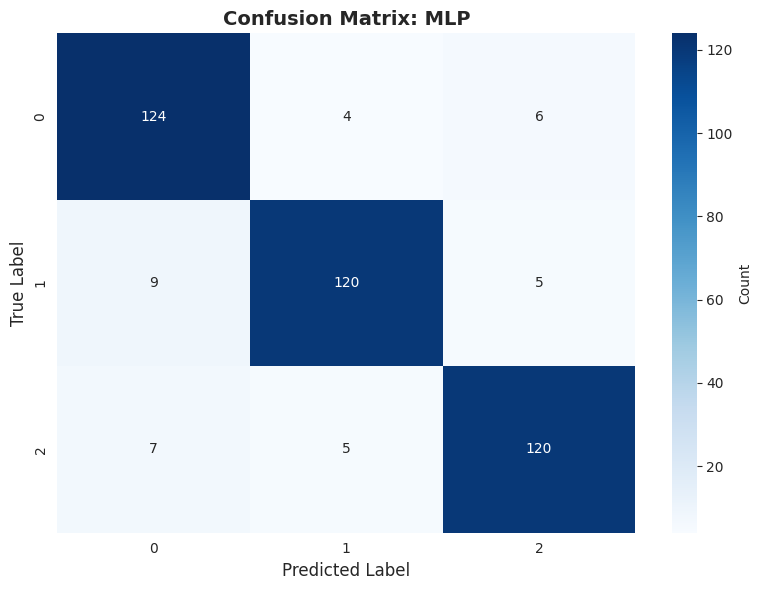

In [9]:
# すべてのモデルを統合して比較
all_models = {
    **models,
    'Voting (Soft)': voting_soft,
    'Stacking': stacking
}

final_comparison = []

for name, model in all_models.items():
    cv_scores_model = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    if not hasattr(model, 'classes_'):
        model.fit(X_train_scaled, y_train)
    
    test_score = model.score(X_test_scaled, y_test)
    
    final_comparison.append({
        'Model': name,
        'CV Mean': cv_scores_model.mean(),
        'CV Std': cv_scores_model.std(),
        'Test': test_score
    })

df_final = pd.DataFrame(final_comparison).sort_values('Test', ascending=False)

print("\nFinal Model Ranking:")
print("="*70)
print(df_final.to_string(index=False))

# 最良モデルの選択
best_model_name = df_final.iloc[0]['Model']
best_model = all_models[best_model_name]

print(f"\n" + "="*70)
print(f"SELECTED MODEL: {best_model_name}")
print("="*70)
print(f"Test Accuracy: {df_final.iloc[0]['Test']:.4f}")
print(f"CV Accuracy:   {df_final.iloc[0]['CV Mean']:.4f} (+/- {df_final.iloc[0]['CV Std']:.4f})")

# 詳細な評価
y_pred = best_model.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 混同行列
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## まとめ

### 🎯 このノートブックで学んだこと

```
1. 公平なモデル比較
   - 同じデータ分割、前処理、評価指標
   - クロスバリデーションで安定した評価
   - Stratified K-Fold でクラス分布を維持

2. 統計的有意性
   - t検定でモデル間の差を検証
   - p値の正しい解釈
   - 多重比較の問題と対策

3. 過学習の診断
   - Train-Test ギャップで判断
   - 対処法（正則化、モデル簡素化）

4. アンサンブル手法
   - Voting（Hard/Soft）
   - Stacking（2段階学習）
   - 多様性の重要性

5. 実践的なモデル選択
   - 性能だけでなく運用要件も考慮
   - ビジネス要件との整合性
```

---

### 📊 モデル比較チートシート

#### 各モデルの特徴

| モデル | 精度 | 速度 | 解釈性 | 過学習リスク | 推奨ケース |
|--------|------|------|--------|-------------|------------|
| **Logistic Regression** | ⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | 低 | ベースライン、解釈重視 |
| **KNN** | ⭐⭐⭐ | ⭐⭐ | ⭐⭐⭐ | 中 | 少データ、パターン明確 |
| **Naive Bayes** | ⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | 低 | テキスト分類、少データ |
| **Decision Tree** | ⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | 高 | 解釈重視、ルール抽出 |
| **Random Forest** | ⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐ | 中 | 汎用、バランス重視 |
| **Gradient Boosting** | ⭐⭐⭐⭐⭐ | ⭐⭐ | ⭐ | 中〜高 | 精度重視、表形式データ |
| **SVM** | ⭐⭐⭐⭐ | ⭐⭐ | ⭐ | 低〜中 | 少〜中データ、高次元 |
| **MLP** | ⭐⭐⭐⭐ | ⭐⭐ | ⭐ | 高 | 複雑なパターン |

---

### 🔧 実践的なワークフロー

```python
# Step 1: ベースラインと候補モデルの準備
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
# ... 他のモデルをインポート

models = {
    'Baseline': LogisticRegression(),
    # ... 他のモデル
}

# Step 2: クロスバリデーションで比較
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Step 3: 統計的検定
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(scores_model_a, scores_model_b)

# Step 4: テストセットで最終評価
best_model.fit(X_train, y_train)
test_score = best_model.score(X_test, y_test)

# Step 5: 過学習チェック
train_score = best_model.score(X_train, y_train)
overfit_gap = train_score - test_score
```

---

### 📋 意思決定フローチャート

```
開始
  │
  ├─ 解釈性が必須？
  │    ├─ Yes → Logistic Regression / Decision Tree
  │    └─ No ↓
  │
  ├─ リアルタイム予測？
  │    ├─ Yes → Logistic Regression / Random Forest
  │    └─ No ↓
  │
  ├─ データサイズは？
  │    ├─ 小 (<1000) → SVM / Naive Bayes
  │    ├─ 中 (1000-100000) → Random Forest / Gradient Boosting
  │    └─ 大 (>100000) → Gradient Boosting / MLP
  │
  ├─ 精度最優先？
  │    ├─ Yes → Stacking / Gradient Boosting
  │    └─ No → 上位2-3モデルから要件で選択
  │
終了
```

---

### ⚠️ よくある間違い

```
❌ テストデータで何度もモデルを調整
   → テストデータへの過適合
   → 正解: CVで調整、テストは最終評価のみ

❌ CVスコアの差だけで判断
   → 統計的に有意でない可能性
   → 正解: t検定で有意差を確認

❌ 単一の評価指標のみ使用
   → 問題の一面しか見ていない
   → 正解: 精度、F1、AUCなど複数指標

❌ 訓練時間を無視
   → 運用で問題になることも
   → 正解: 性能と効率のトレードオフを考慮

❌ 最高精度のモデルを常に選択
   → 解釈性、保守性が犠牲に
   → 正解: ビジネス要件との整合性を確認
```

---

### ✅ 学習チェックリスト

- [ ] クロスバリデーションの目的と仕組みを説明できる
- [ ] Stratified K-Fold がなぜ必要か理解している
- [ ] 対応のあるt検定の意味と使い方を知っている
- [ ] 過学習の診断と対処法を説明できる
- [ ] Voting と Stacking の違いを説明できる
- [ ] 要件に応じたモデル選択ができる

---

### 📚 練習問題

1. **CV比較**: Irisデータセットで5つのモデルをCVで比較し、ランキングを作成してください

2. **統計的検定**: 上位2モデルの差がt検定で有意かを確認してください

3. **アンサンブル**: Soft Voting と Stacking を実装し、単一モデルと比較してください

4. **要件マッチング**: 以下のケースで最適なモデルを選んでください:
   - 銀行の与信判断（解釈性必須）
   - リアルタイムの不正検知
   - Kaggleコンペティション

5. **過学習対策**: Decision Treeの過学習を、max_depthを調整して改善してください

---

**次のステップ**: ノートブック12で、完全なMLパイプラインを構築し、本番環境へのデプロイを準備します!